In [1]:
! mkdir /kaggle/working/FaceSet
! cp -R /kaggle/input/boodyset/Faces /kaggle/working/FaceSet
! cp -R /kaggle/input/boodz/Boodz_ /kaggle/working/FaceSet
! cp -R /kaggle/input/noorset/NoorSet /kaggle/working/FaceSet

In [2]:
import os 
os.rename("/kaggle/working/FaceSet/Boodz_","/kaggle/working/FaceSet/Boodz")
os.rename("/kaggle/working/FaceSet/Faces","/kaggle/working/FaceSet/Boody")
os.rename("/kaggle/working/FaceSet/NoorSet","/kaggle/working/FaceSet/Noor")

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.io import read_image
import torchvision.transforms as transforms
import time
import copy
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = []
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # Populate the img_labels list with tuples of image paths and labels
        for label_folder in os.listdir(img_dir):
            label_folder_path = os.path.join(img_dir, label_folder)
            if os.path.isdir(label_folder_path):
                for img_file in os.listdir(label_folder_path):
                    self.img_labels.append((os.path.join(label_folder, img_file), label_folder))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        full_img_path = os.path.join(self.img_dir, img_path)
        image = Image.open(full_img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        label = classes.index(label)
        label = torch.tensor(label)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [87]:
whdim= 64 ## resize to w = 64, h = 64
# Define your transforms
transform = transforms.Compose([
    
    transforms.Resize((whdim, whdim)),          # Resize the image to 256x256 pixels
#     transforms.RandomHorizontalFlip(),      # Randomly flip the image horizontally
#     transforms.RandomRotation(10),          # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),                  # Convert the image to a PyTorch tensor
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])


# Create the dataset
dataset = CustomImageDataset(img_dir='/kaggle/working/FaceSet', transform=transform)

train_size = int(0.7 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = int(0.2 * len(dataset))

trainset, testset,valset, _ = torch.utils.data.random_split(dataset, [train_size,test_size, val_size,  len(dataset)-train_size-test_size-val_size])



# Create a DataLoader
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)
valloader = DataLoader(valset, batch_size=32, shuffle=False)

In [88]:
classes = ("Boody","Boodz","Noor")

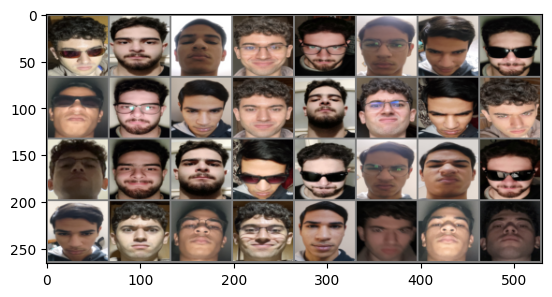

In [840]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

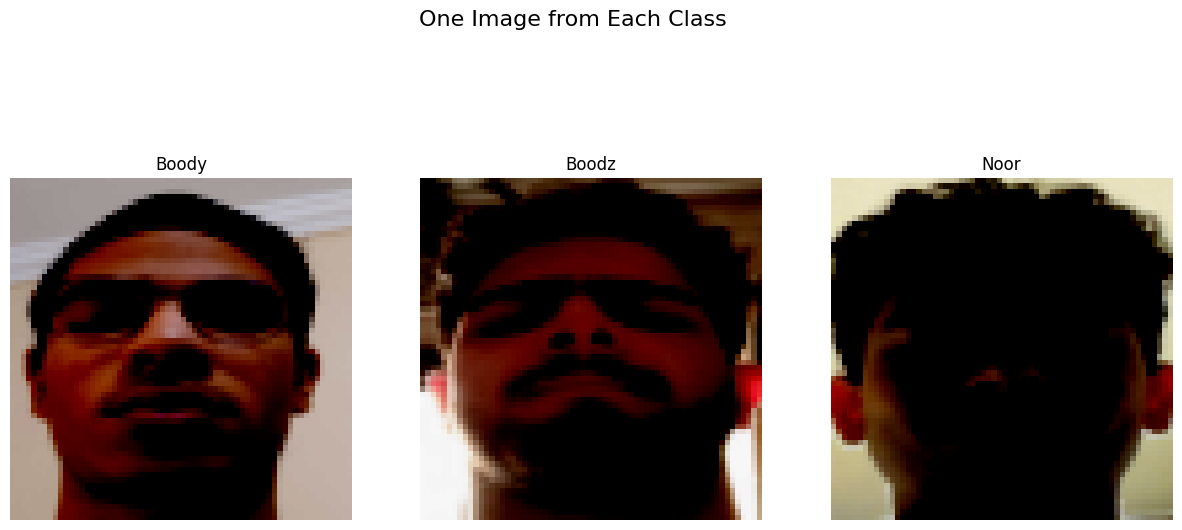

In [90]:
# Create a dictionary to store one image from each class
class_images = {class_name: None for class_name in classes}

# Find one image from each class
for data, target in dataset:
    if class_images[classes[target]] is None:
        class_images[classes[target]] = data
    if all(image is not None for image in class_images.values()):
        break

# Plot one image from each class
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle('One Image from Each Class', fontsize=16)

for i, (class_name, image) in enumerate(class_images.items()):
    col = i
    axs[col].imshow(np.transpose(image.numpy(), (1, 2, 0)))
    axs[col].set_title(class_name)
    axs[col].axis('off')

plt.show()

In [91]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [92]:
from torchsummary import summary

In [122]:
# Define the VAE model using PyTorch
class VAE(nn.Module):
    def __init__(self, original_dim, latent_dim):
        super(VAE, self).__init__()
        self.conv = nn.Conv2d(3,3,3,1,1)
        self.conv1 = nn.Conv2d(3,2,3,2)
#         self.conv2 = nn.Conv2d(2,2,3,2)

        self.encoder = nn.Sequential(
            nn.Linear(original_dim,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()

#             nn.Linear(1024,latent_dim ),
#             nn.ReLU()
        )
        self.fc21 = nn.Linear(64, latent_dim)
        self.fc22 = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,64 ),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048,original_dim)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    def reparameterize2(self, mu, log_var,eps):
        std = torch.exp(0.5 * log_var)
        return mu + eps*std
    def forward(self, x):
        x = nn.Flatten(1)(x)
        m = self.encoder(x)
        mu, log_var = self.fc21(m), self.fc22(m)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var
    def forward2(self, x,eps=1):
#         x = self.conv(x)
#         x = nn.ReLU()(x)
#         x = self.conv1(x)
#         x = nn.ReLU()(x)
#         x = self.conv2(x)
        x = nn.Flatten(1)(x)
        m = self.encoder(x)
        mu, log_var = self.fc21(m), self.fc22(m)
        z = self.reparameterize2(mu, log_var,eps=eps)
        return self.decoder(z), mu, log_var

In [185]:
# Loss function
def loss_function(recon_x, x, mu, log_var):
    B = 1.4
    BCE = F.mse_loss(recon_x, x.view(-1, whdim*whdim*3))
#     print("BCE",BCE)
    # F.binary_cross_entropy(recon_x, x.view(-1, 256*256*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    KLD /= x.size(0) * 128 * 128 * 3
#     print("KLD",KLD)
    return BCE + KLD*B

In [805]:
# Instantiate the VAE model
original_dim = whdim
# intermediate_dim = 64
latent_dim = 4
vae_model = VAE(whdim*whdim*3,latent_dim =latent_dim)

In [806]:
summary(vae_model.to("cuda"),(3,whdim,whdim),32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [32, 1024]      12,583,936
       BatchNorm1d-2                 [32, 1024]           2,048
              ReLU-3                 [32, 1024]               0
            Linear-4                  [32, 512]         524,800
       BatchNorm1d-5                  [32, 512]           1,024
              ReLU-6                  [32, 512]               0
            Linear-7                  [32, 256]         131,328
       BatchNorm1d-8                  [32, 256]             512
              ReLU-9                  [32, 256]               0
           Linear-10                  [32, 128]          32,896
      BatchNorm1d-11                  [32, 128]             256
             ReLU-12                  [32, 128]               0
           Linear-13                   [32, 64]           8,256
      BatchNorm1d-14                   

In [807]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, model_save_path, device, learning_rate=0.001, num_epochs=10, patience=5):
    criterion = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience//2, verbose=True)

    # Early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Lists to store metrics
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        # Training Phase
        model.train()
        total_train_loss = 0

        for inputs,_ in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(inputs)
            loss = criterion(recon_batch, inputs, mu, log_var)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for inputs,_ in val_loader:
                inputs = inputs.to(device)
                recon_batch, mu, log_var = model(inputs)
                loss = criterion(recon_batch, inputs, mu, log_var)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Print epoch's summary
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Scheduler and Early Stopping
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break

        # Plotting
        plt.figure(figsize=(6, 3))
        plt.plot(range(1, epoch + 2), train_losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return best_val_loss

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.4064, Val Loss: 0.2916


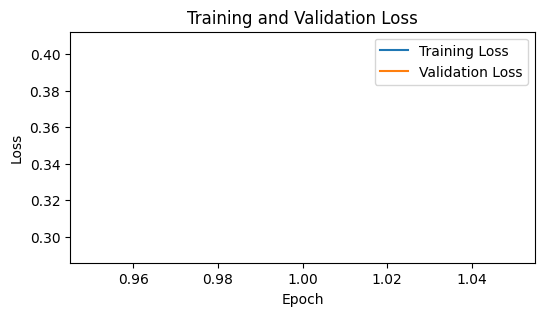

  5%|▌         | 1/20 [00:08<02:37,  8.30s/it]

Epoch [2/20], Train Loss: 0.2675, Val Loss: 0.2056


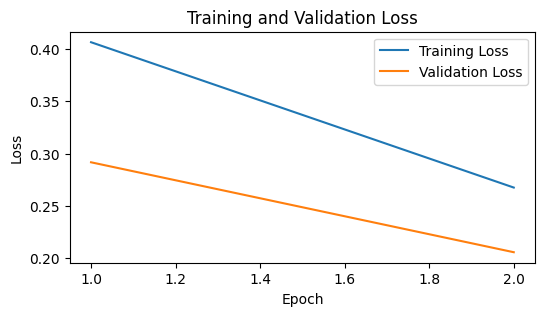

 10%|█         | 2/20 [00:16<02:29,  8.28s/it]

Epoch [3/20], Train Loss: 0.2170, Val Loss: 0.1995


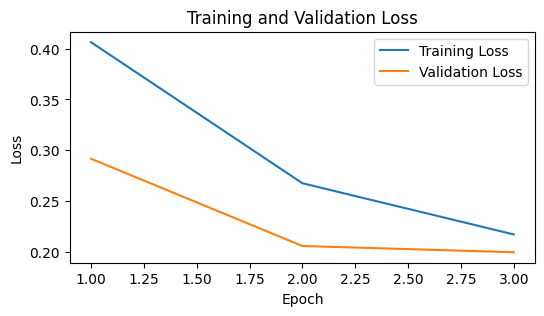

 15%|█▌        | 3/20 [00:24<02:19,  8.23s/it]

Epoch [4/20], Train Loss: 0.1805, Val Loss: 0.2197


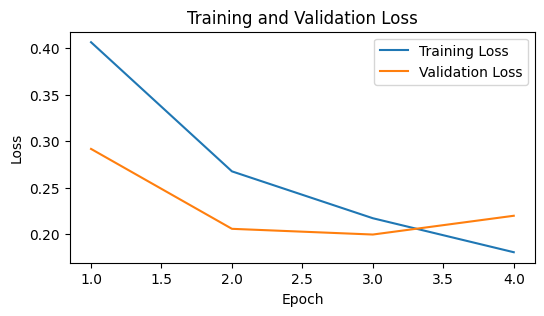

 20%|██        | 4/20 [00:32<02:08,  8.03s/it]

Epoch [5/20], Train Loss: 0.1734, Val Loss: 0.1554


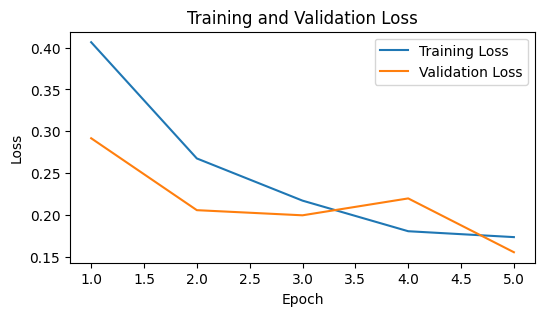

 25%|██▌       | 5/20 [00:40<02:01,  8.10s/it]

Epoch [6/20], Train Loss: 0.1639, Val Loss: 0.1509


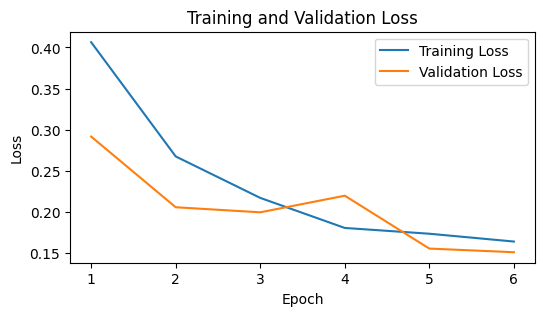

 30%|███       | 6/20 [00:48<01:53,  8.11s/it]

Epoch [7/20], Train Loss: 0.1490, Val Loss: 0.1414


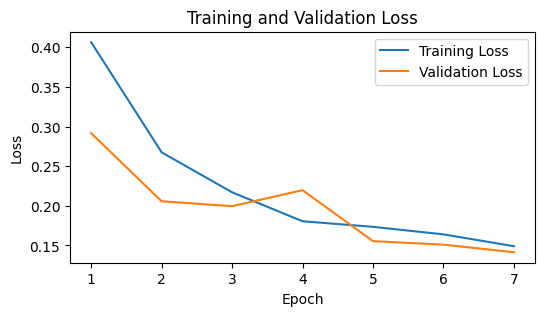

 35%|███▌      | 7/20 [00:56<01:45,  8.13s/it]

Epoch [8/20], Train Loss: 0.1422, Val Loss: 0.1351


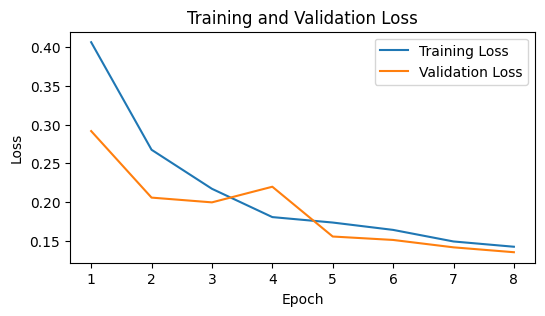

 40%|████      | 8/20 [01:05<01:37,  8.12s/it]

Epoch [9/20], Train Loss: 0.1412, Val Loss: 0.1346


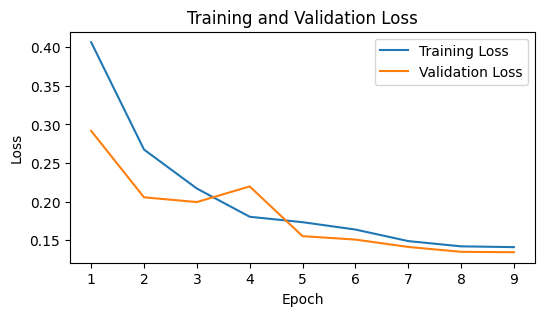

 45%|████▌     | 9/20 [01:13<01:29,  8.15s/it]

Epoch [10/20], Train Loss: 0.1394, Val Loss: 0.1287


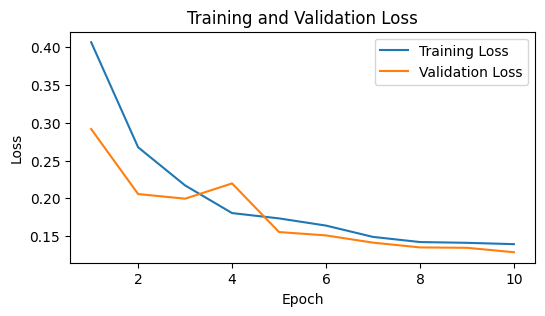

 50%|█████     | 10/20 [01:21<01:21,  8.13s/it]

Epoch [11/20], Train Loss: 0.1348, Val Loss: 0.1338


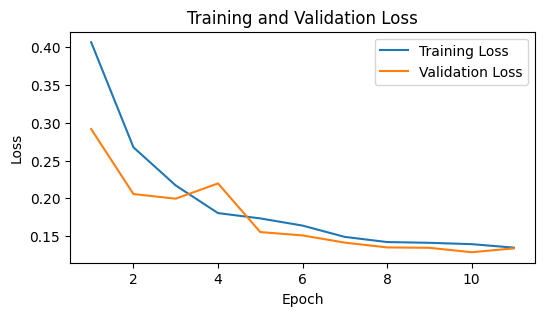

 55%|█████▌    | 11/20 [01:29<01:12,  8.02s/it]

Epoch [12/20], Train Loss: 0.1360, Val Loss: 0.1234


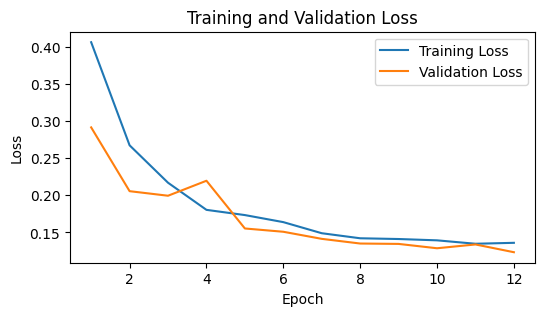

 60%|██████    | 12/20 [01:37<01:04,  8.02s/it]

Epoch [13/20], Train Loss: 0.1466, Val Loss: 0.1399


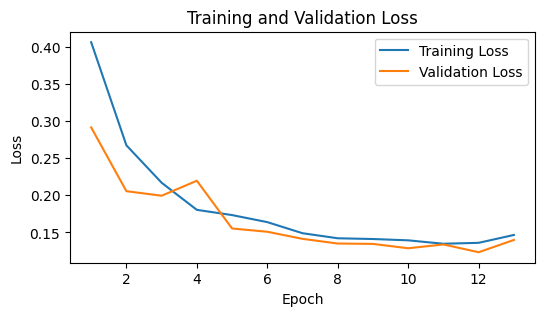

 65%|██████▌   | 13/20 [01:44<00:55,  7.93s/it]

Epoch [14/20], Train Loss: 0.1458, Val Loss: 0.1236


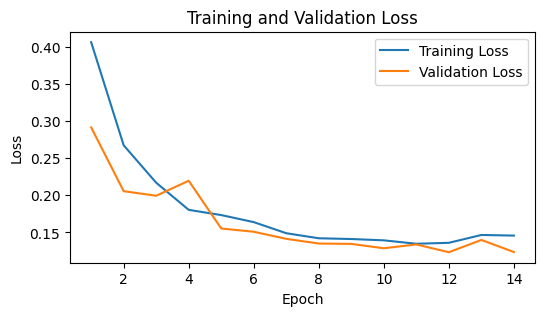

 70%|███████   | 14/20 [01:52<00:47,  7.84s/it]

Epoch [15/20], Train Loss: 0.1288, Val Loss: 0.1169


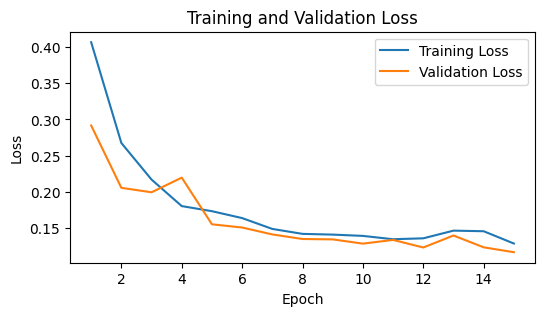

 75%|███████▌  | 15/20 [02:00<00:39,  7.90s/it]

Epoch [16/20], Train Loss: 0.1332, Val Loss: 0.1206


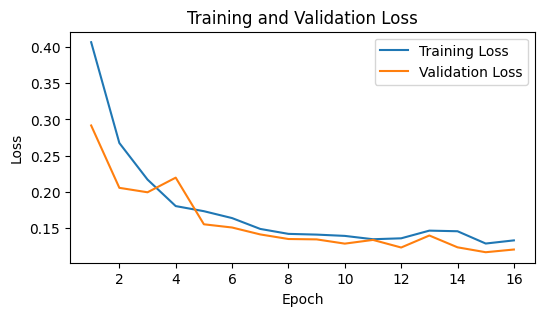

 80%|████████  | 16/20 [02:08<00:31,  7.86s/it]

Epoch [17/20], Train Loss: 0.1293, Val Loss: 0.1247


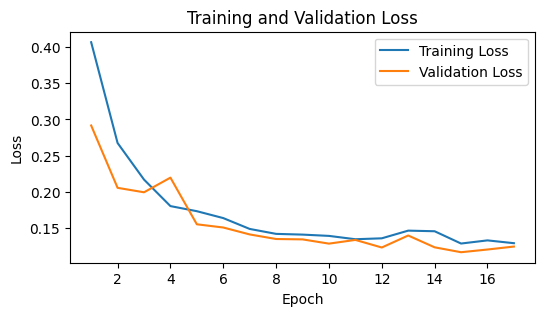

 85%|████████▌ | 17/20 [02:16<00:23,  7.84s/it]

Epoch [18/20], Train Loss: 0.1254, Val Loss: 0.1122


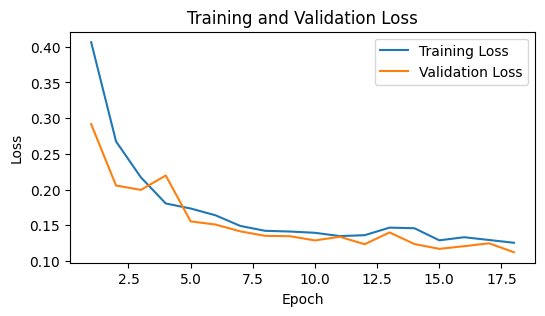

 90%|█████████ | 18/20 [02:24<00:15,  7.92s/it]

Epoch [19/20], Train Loss: 0.1218, Val Loss: 0.1177


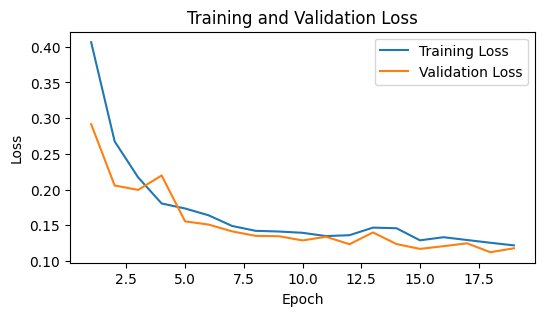

 95%|█████████▌| 19/20 [02:31<00:07,  7.86s/it]

Epoch [20/20], Train Loss: 0.1176, Val Loss: 0.1099


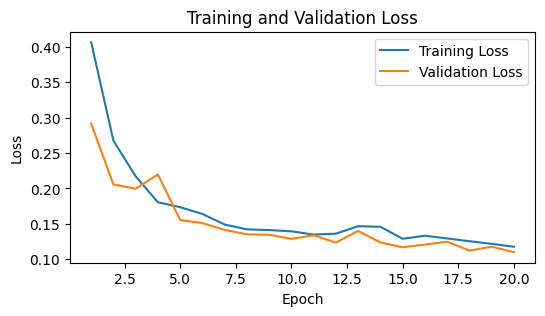

100%|██████████| 20/20 [02:39<00:00,  8.00s/it]


In [808]:
learning_rate = 0.001
num_epochs = 20
patience=5
model_save_path = 'model.pth'
vae_model.to("cuda")
best_model_stats = train(vae_model, trainloader, valloader, learning_rate=learning_rate,
                num_epochs=num_epochs, patience=patience, model_save_path=model_save_path,device = "cuda")

In [809]:
vae_model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [810]:
batch = next(iter(valloader))

In [811]:
# eps = np.ones(64)
# for i in range(64):
#     if(i < 5):
#         eps[i] = 5 

# eps = torch.Tensor(eps).to("cuda")

In [812]:
# eps = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
#        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
#        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., -11., -11., -11., 1.,
#        12., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]
# eps = torch.Tensor(eps).to("cuda")

In [813]:
output,_,_ = vae_model.forward2(batch[0].to("cuda"), 2)

In [814]:
inv_norm = transforms.Normalize((-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), (1 / 0.5, 1 / 0.5, 1 / 0.5))
output = inv_norm(output.view(-1,3,whdim, whdim))

In [815]:
bat = inv_norm(batch[0].view(-1,3,whdim,whdim))

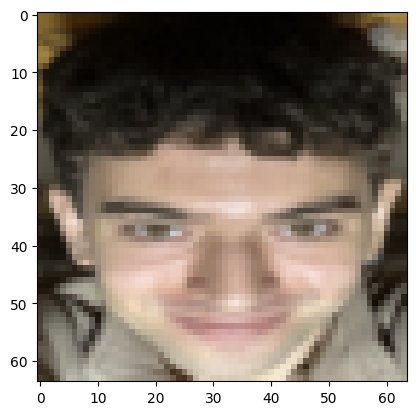

In [816]:
idx = 6
plt.imshow(bat[idx].permute(1,2,0).detach().cpu().numpy())

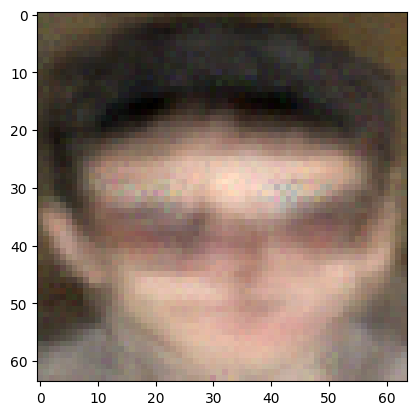

In [817]:
plt.imshow(output[idx].permute(1,2,0).detach().cpu().numpy())

In [818]:
output,_,_ = vae_model.forward2(batch[0].to("cuda"), 1)
inv_norm = transforms.Normalize((-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), (1 / 0.5, 1 / 0.5, 1 / 0.5))
output = inv_norm(output.view(-1,3,whdim, whdim))

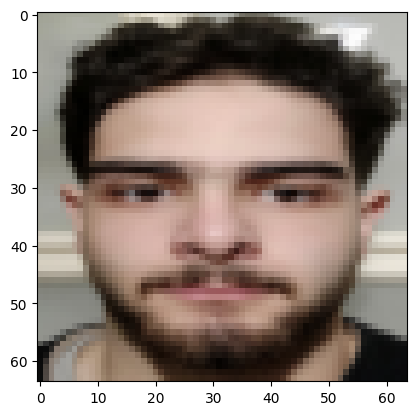

In [819]:
idx = 13
plt.imshow(bat[idx].permute(1,2,0).detach().cpu().numpy())

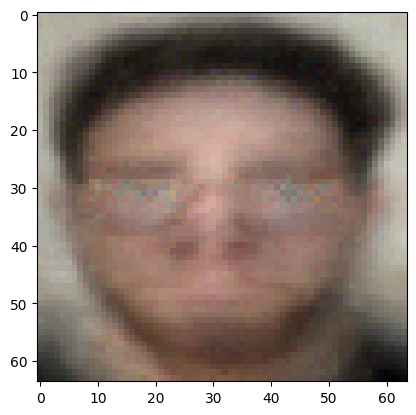

In [820]:
plt.imshow(output[idx].permute(1,2,0).detach().cpu().numpy())

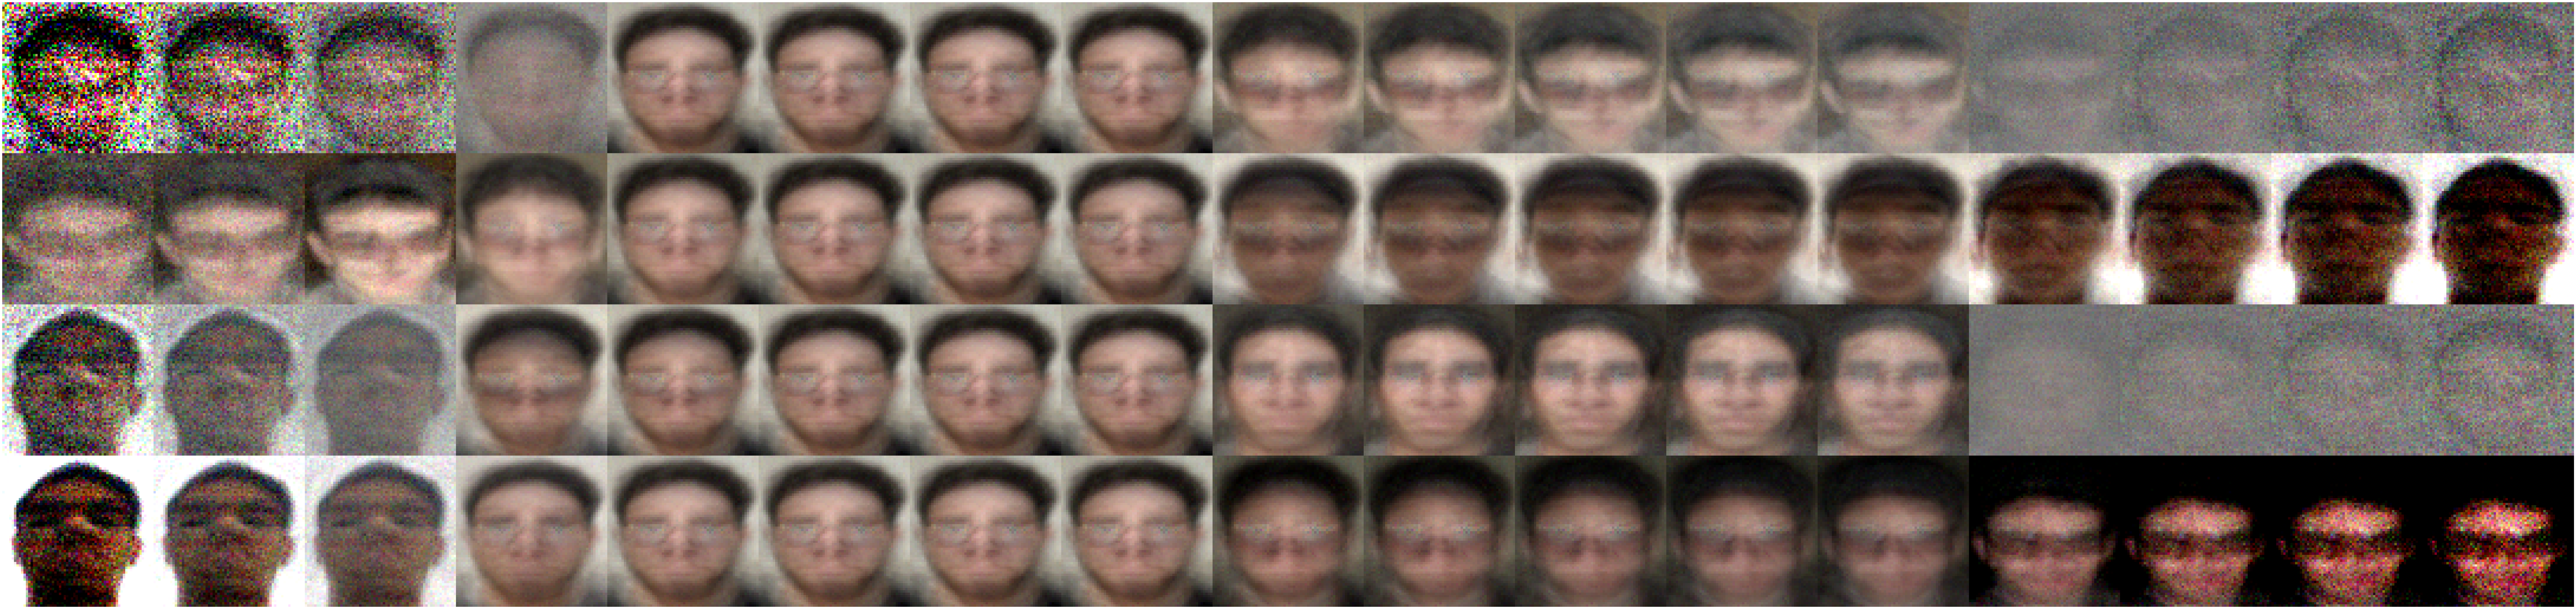

In [841]:
# Initialize an empty grid for the images
eps = [-50,-30,-20,-5,-2, -1, 0, 1, 6,7,8,9,10,20,30,40,50]  # Example values

image_grid = np.zeros((latent_dim * whdim, len(eps) * whdim, 3))

# Generate images
for i in range(latent_dim):  # Iterate over each latent feature
    for j, scale in enumerate(eps):  # Iterate over each value in eps
        # Create a latent vector where all values are zero except the i-th feature
        z = torch.zeros((1, latent_dim)).cuda()
        z[0, i] = scale

        # Generate an image from the latent vector
        with torch.no_grad():
            output, _, _ = vae_model.forward2(batch[0][idx].unsqueeze(0).to("cuda"),z)
            output = inv_norm(output.view(3, whdim, whdim))
            output = output.cpu().numpy().transpose(1, 2, 0)  # Convert to numpy array and adjust dimensions

        # Place the generated image in the correct position in the grid
        image_grid[i * whdim:(i + 1) * whdim, j * whdim:(j + 1) * whdim, :] = output

# Plot the grid of images
plt.figure(figsize=(150, 50))
plt.imshow(image_grid)
plt.axis('off')
plt.show()

In [481]:
def train_cvae(model, train_loader, val_loader, model_save_path, device, learning_rate=0.001, num_epochs=10, patience=5):
    criterion = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience//2, verbose=True)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_train_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(inputs, labels)
            loss = criterion(recon_batch, inputs, mu, log_var)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                recon_batch, mu, log_var = model(inputs, labels)
                loss = criterion(recon_batch, inputs, mu, log_var)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break

        plt.figure(figsize=(6, 3))
        plt.plot(range(1, epoch + 2), train_losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return best_val_loss


In [715]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, original_dim, latent_dim, num_classes):
        super(CVAE, self).__init__()
        self.num_classes = num_classes
        
        # Convolution layers
        self.conv1 = nn.Conv2d(3, 2, 3, 2)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(1922 + num_classes, 1024), ## 3 [0,0,1]
#             nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.fc21 = nn.Linear(64, latent_dim)
        self.fc22 = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, original_dim)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    def reparameterize2(self, mu, log_var, eps=1):
        std = torch.exp(0.5 * log_var)
        return mu + eps * std
    
    def forward2(self, x, labels):
        # One-hot encode labels
        one_hot_labels = F.one_hot(labels, num_classes=self.num_classes).float()
#         print(one_hot_labels)
        # Apply convolution layers
        x = F.relu(self.conv1(x))

        # Flatten and concatenate with labels
        x = torch.flatten(x, 1)
        x = torch.cat([x, one_hot_labels], dim=1)

        # Encoder
        m = self.encoder(x)
        mu, log_var = self.fc21(m), self.fc22(m)
        z = self.reparameterize2(mu, log_var)

        # Concatenate z with labels for decoder
        z = torch.cat([z, one_hot_labels], dim=1)
        return self.decoder(z), mu, log_var

    def forward(self, x, labels):
        # One-hot encode labels
        one_hot_labels = F.one_hot(labels, num_classes=self.num_classes).float()
        
        # Apply convolution layers
        x = F.relu(self.conv1(x))

        # Flatten and concatenate with labels
        x = torch.flatten(x, 1)
        x = torch.cat([x, one_hot_labels], dim=1)

        # Encoder
        m = self.encoder(x)
        mu, log_var = self.fc21(m), self.fc22(m)
        z = self.reparameterize(mu, log_var)

        # Concatenate z with labels for decoder
        z = torch.cat([z, one_hot_labels], dim=1)
        return self.decoder(z), mu, log_var


In [789]:
original_dim = whdim * whdim * 3  # For 64x64 RGB images
latent_dim = 4  # Size of the latent space
num_classes = 3  # Example: 3 classes, change this based on your dataset

cvae_model = CVAE(original_dim, latent_dim, num_classes)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 0.3848, Val Loss: 0.2986


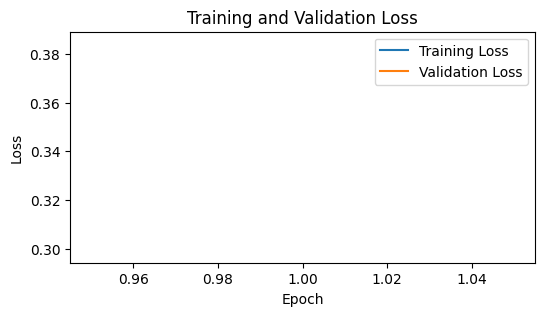

  3%|▎         | 1/30 [00:08<03:55,  8.11s/it]

Epoch [2/30], Train Loss: 0.2381, Val Loss: 0.2371


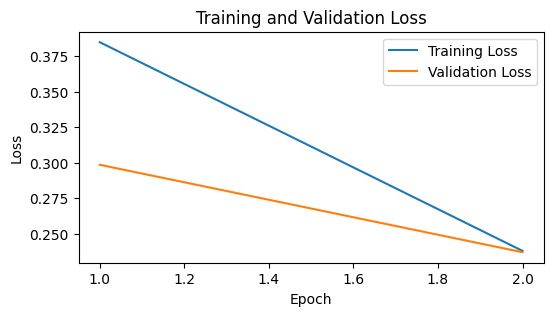

  7%|▋         | 2/30 [00:16<03:45,  8.06s/it]

Epoch [3/30], Train Loss: 0.1861, Val Loss: 0.1779


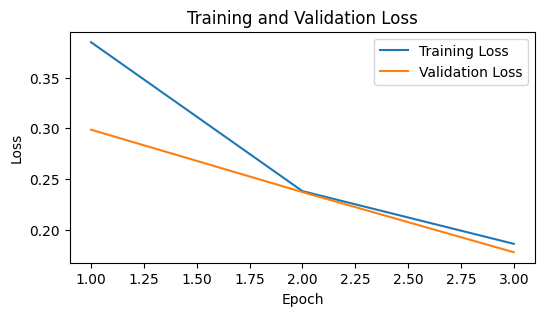

 10%|█         | 3/30 [00:24<03:38,  8.11s/it]

Epoch [4/30], Train Loss: 0.1719, Val Loss: 0.1575


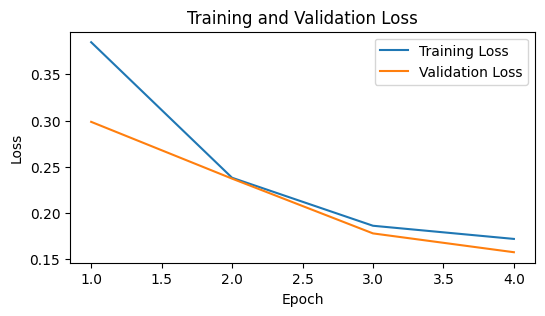

 13%|█▎        | 4/30 [00:32<03:29,  8.05s/it]

Epoch [5/30], Train Loss: 0.1589, Val Loss: 0.1332


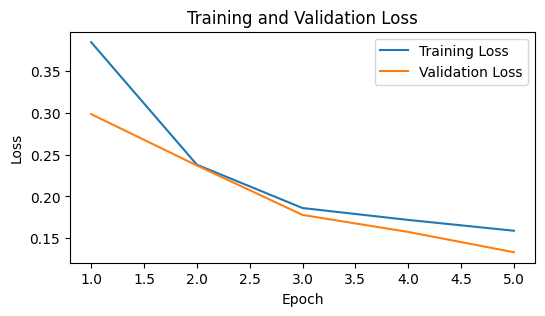

 17%|█▋        | 5/30 [00:40<03:20,  8.03s/it]

Epoch [6/30], Train Loss: 0.1442, Val Loss: 0.1347


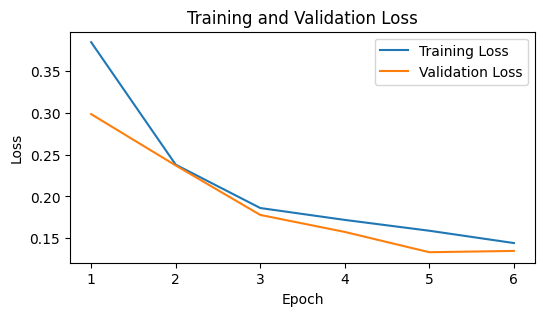

 20%|██        | 6/30 [00:47<03:10,  7.92s/it]

Epoch [7/30], Train Loss: 0.1365, Val Loss: 0.1232


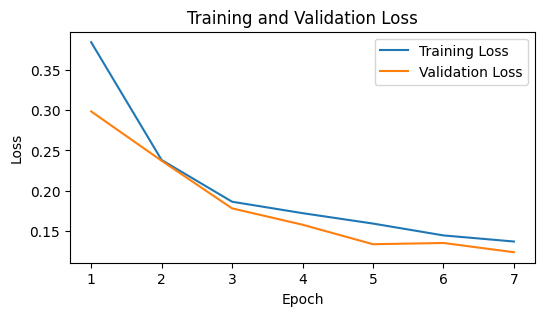

 23%|██▎       | 7/30 [00:56<03:03,  7.97s/it]

Epoch [8/30], Train Loss: 0.1364, Val Loss: 0.1206


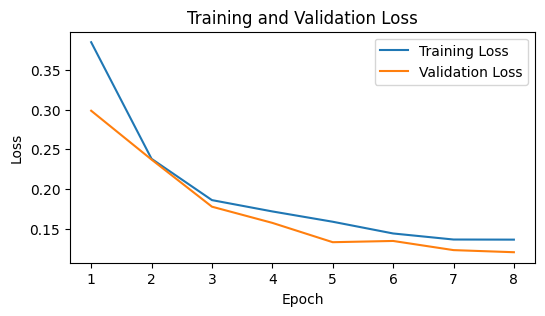

 27%|██▋       | 8/30 [01:04<02:55,  7.99s/it]

Epoch [9/30], Train Loss: 0.1290, Val Loss: 0.1160


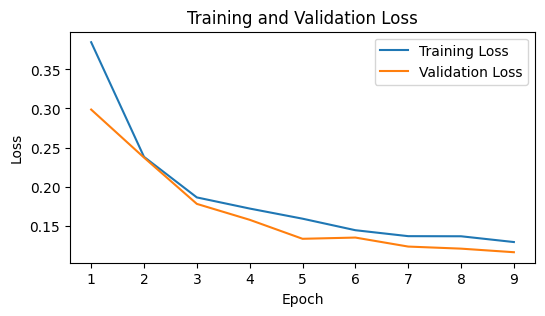

 30%|███       | 9/30 [01:11<02:47,  7.97s/it]

Epoch [10/30], Train Loss: 0.1262, Val Loss: 0.1128


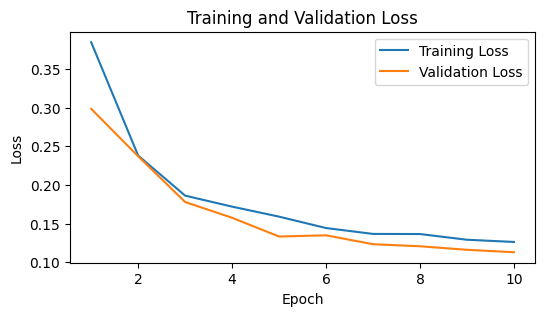

 33%|███▎      | 10/30 [01:20<02:39,  7.99s/it]

Epoch [11/30], Train Loss: 0.1245, Val Loss: 0.1159


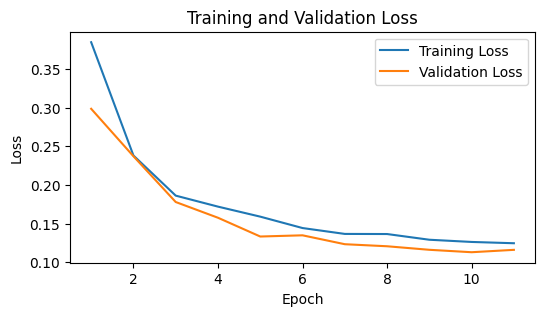

 37%|███▋      | 11/30 [01:27<02:30,  7.91s/it]

Epoch [12/30], Train Loss: 0.1174, Val Loss: 0.1112


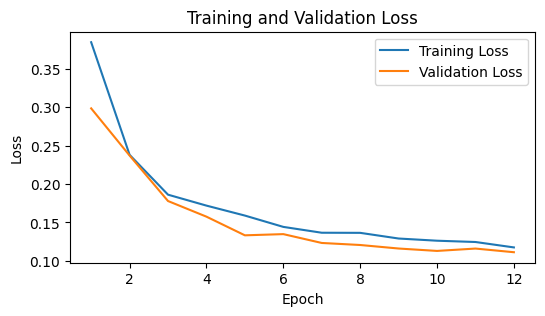

 40%|████      | 12/30 [01:35<02:22,  7.93s/it]

Epoch [13/30], Train Loss: 0.1252, Val Loss: 0.1191


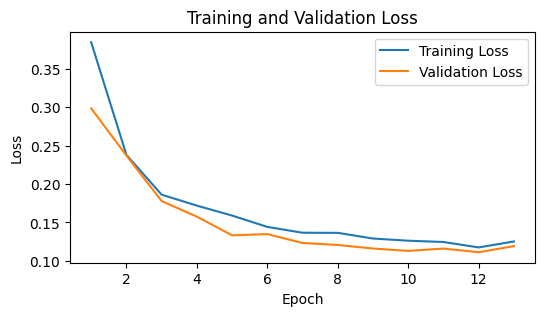

 43%|████▎     | 13/30 [01:43<02:13,  7.85s/it]

Epoch [14/30], Train Loss: 0.1278, Val Loss: 0.1180


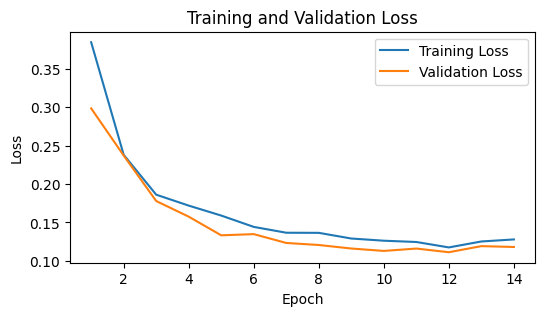

 47%|████▋     | 14/30 [01:51<02:04,  7.80s/it]

Epoch [15/30], Train Loss: 0.1204, Val Loss: 0.1140
Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


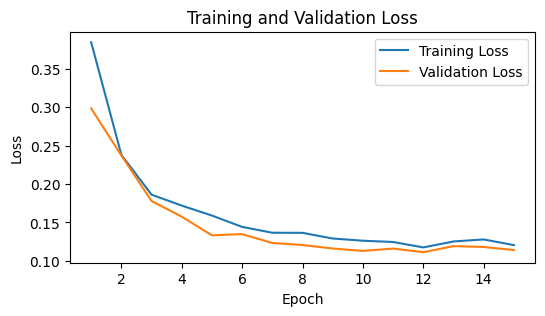

 50%|█████     | 15/30 [01:58<01:57,  7.81s/it]

Epoch [16/30], Train Loss: 0.1116, Val Loss: 0.1060


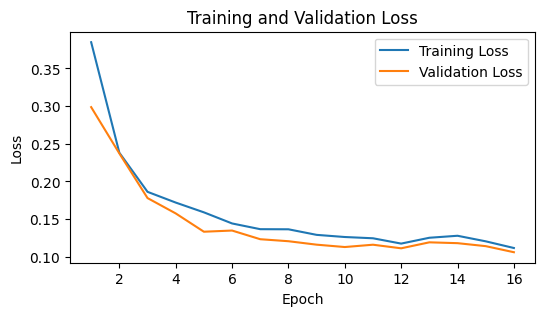

 53%|█████▎    | 16/30 [02:06<01:50,  7.87s/it]

Epoch [17/30], Train Loss: 0.1047, Val Loss: 0.1030


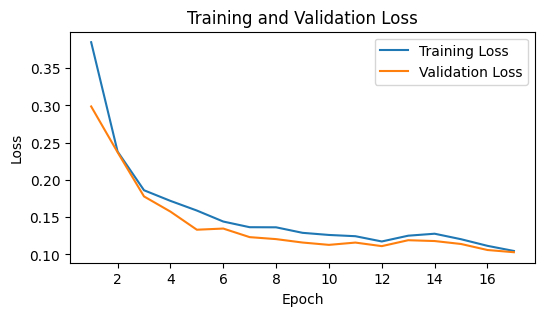

 57%|█████▋    | 17/30 [02:14<01:42,  7.92s/it]

Epoch [18/30], Train Loss: 0.1052, Val Loss: 0.1023


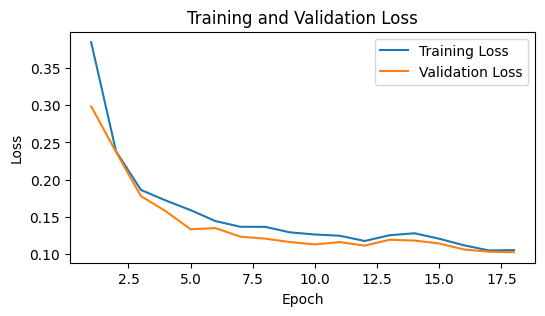

 60%|██████    | 18/30 [02:23<01:35,  7.96s/it]

Epoch [19/30], Train Loss: 0.1014, Val Loss: 0.1010


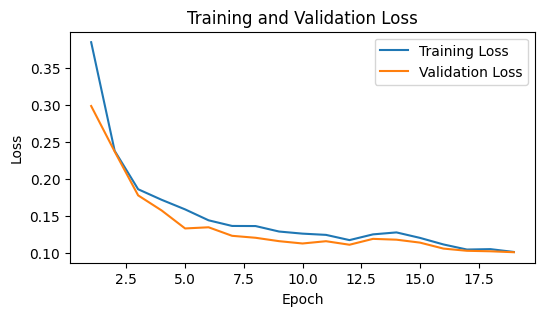

 63%|██████▎   | 19/30 [02:32<01:31,  8.31s/it]

Epoch [20/30], Train Loss: 0.1017, Val Loss: 0.0980


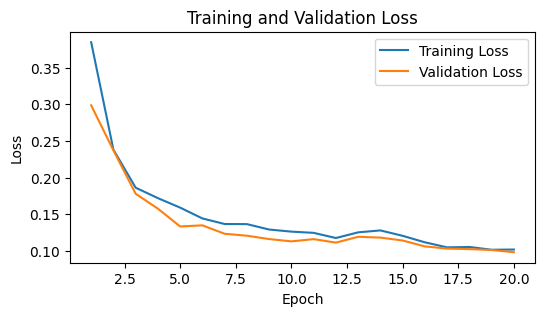

 67%|██████▋   | 20/30 [02:40<01:22,  8.29s/it]

Epoch [21/30], Train Loss: 0.1018, Val Loss: 0.1009


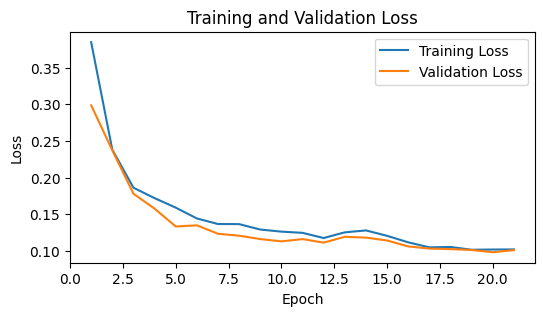

 70%|███████   | 21/30 [02:48<01:13,  8.14s/it]

Epoch [22/30], Train Loss: 0.1049, Val Loss: 0.0991


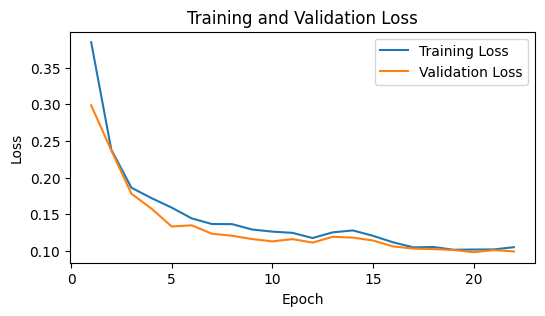

 73%|███████▎  | 22/30 [02:55<01:04,  8.04s/it]

Epoch [23/30], Train Loss: 0.1075, Val Loss: 0.0980
Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.


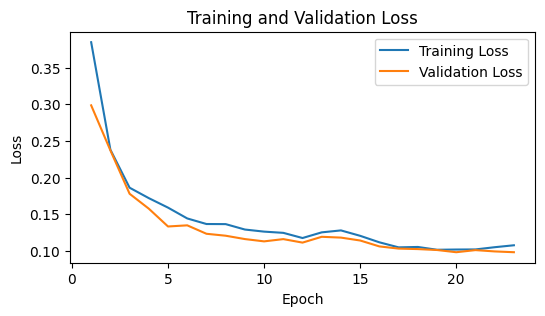

 77%|███████▋  | 23/30 [03:03<00:55,  7.93s/it]

Epoch [24/30], Train Loss: 0.0957, Val Loss: 0.1009


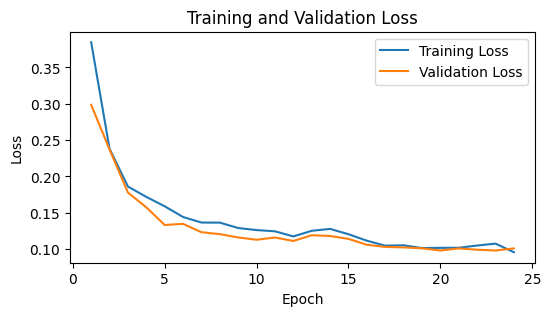

 80%|████████  | 24/30 [03:18<00:49,  8.29s/it]

Epoch [25/30], Train Loss: 0.1010, Val Loss: 0.0981
Early stopping triggered after 25 epochs


In [790]:
learning_rate = 0.001
num_epochs = 30
patience = 5
model_save_path = 'cvae_model.pth'
cvae_model.to("cuda")
best_model_stats = train_cvae(cvae_model, trainloader, valloader, model_save_path, "cuda", learning_rate, num_epochs, patience)

In [791]:
cvae_model.load_state_dict(torch.load('/kaggle/working/cvae_model.pth'))

<All keys matched successfully>

In [792]:
classes

('Boody', 'Boodz', 'Noor')

In [793]:
boodz = 0
noor = 1
boody = -1

In [794]:
batch = next(iter(trainloader))

In [795]:
lbls = np.ones(32).astype(int) + noor
output,_,_ = cvae_model.forward2(batch[0].to("cuda"), torch.Tensor(lbls).to(torch.int64).to("cuda"))
inv_norm = transforms.Normalize((-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), (1 / 0.5, 1 / 0.5, 1 / 0.5))
output_noor = inv_norm(output.view(-1,3,whdim, whdim))

In [796]:
lbls = np.ones(32).astype(int) + boody
output,_,_ = cvae_model.forward2(batch[0].to("cuda"), torch.Tensor(lbls).to(torch.int64).to("cuda"))
inv_norm = transforms.Normalize((-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), (1 / 0.5, 1 / 0.5, 1 / 0.5))
output_boody = inv_norm(output.view(-1,3,whdim, whdim))

lbls = np.ones(32).astype(int) + boodz
output,_,_ = cvae_model.forward2(batch[0].to("cuda"), torch.Tensor(lbls).to(torch.int64).to("cuda"))
inv_norm = transforms.Normalize((-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), (1 / 0.5, 1 / 0.5, 1 / 0.5))
output_boodz = inv_norm(output.view(-1,3,whdim, whdim))

In [797]:
outputs = [output_boody, output_boodz, output_noor]

In [803]:
idx = 6

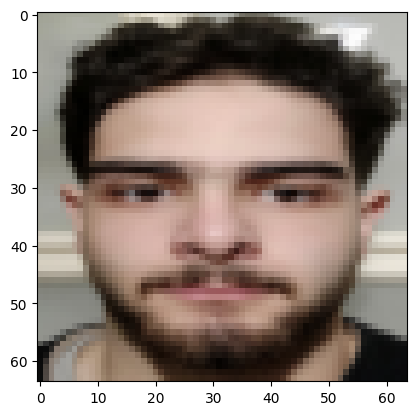

In [830]:
plt.imshow(inv_norm(batch[0][idx]).permute(1,2,0).detach().cpu().numpy())

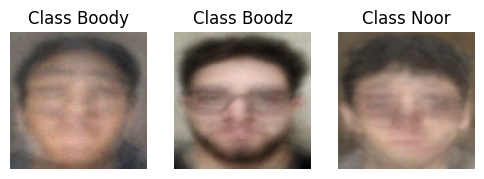

In [804]:
fig, axes = plt.subplots(1, 3, figsize=(num_classes * 2, 2))
for i in range(3):
    axes[i].imshow(outputs[i][idx].permute(1,2,0).detach().cpu().numpy())
    axes[i].axis('off')
    axes[i].set_title(f'Class {classes[i]}')

In [822]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def GUI(idx):
    batches = []
    outputs= [] 
    batch_num,idx2 = divmod(idx,32)
    for i in range(batch_num+1):
        batches.append(next(iter(valloader)))
        output, _, _ = vae_model.forward2(batches[i][0].to("cuda"), 1)
        outputs.append(output)
        
    inv_norm = transforms.Normalize((-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), (1 / 0.5, 1 / 0.5, 1 / 0.5))
    output = inv_norm(outputs[batch_num].view(-1, 3, 64, 64))
    
    # Display the generated image
    plt.imshow(output[idx2].permute(1, 2, 0).detach().cpu().numpy())
    plt.axis('off')  # Hide the axes
    plt.show()
    
slider = widgets.IntSlider(min=0, max=100, step=1, description='Image Index')
widgets.interactive(GUI, idx=slider)


interactive(children=(IntSlider(value=0, description='Image Index'), Output()), _dom_classes=('widget-interact…